In [1]:
# Import necessary libraries (Using qiskit v2)
from qiskit import QuantumCircuit, transpile
from qiskit.converters import circuit_to_dag, dag_to_circuit
import matplotlib.pyplot as plt

In [2]:
from qiskit.circuit.controlflow import IfElseOp
from qiskit.circuit import Measure
from qiskit.dagcircuit import DAGInNode

# Traverse the DAG and optimize unnecessary IfElseOp nodes
def collapse_if_else(circuit):

    # measurements between IfElseOp nodes will invalidate the known conditionals
    def get_valid_conditionals(dag, node, conditionals):
        valid_conditionals = []
        for cond in conditionals:
            valid = True
            carg = cond[0]

            for anc in dag.ancestors(node):
                if isinstance(anc, DAGInNode):
                    continue
                if not isinstance(anc.op, Measure):
                    continue
                if anc.cargs[0] == carg:
                    # cond is not valid
                    valid = False
                    break
            if valid:
                valid_conditionals.append(cond)
        return valid_conditionals

    def dfs_dag(dag, conditionals):
        for child in dag.op_nodes(IfElseOp):
            valid_conditionals = get_valid_conditionals(dag, child, conditionals)
            dfs_node(dag, child, valid_conditionals)

    def dfs_node(dag, node, conditionals):
        # check if node.op.condition in conditionals
        # if found, replace with the corresponding block
        for cond in conditionals:
            if cond[0] == node.op.condition[0]:
                block_kept_idx = cond[1] ^ node.op.condition[1] # 0 (true_body) if both values are equal, otherwise 1 (else_body)
                if block_kept_idx >= len(node.op.blocks):
                    # condition is not met and no else block
                    # remove entire if-else node
                    dag.remove_op_node(node)
                    return

                # recurse on the relevant block
                block_dag = circuit_to_dag(node.op.blocks[block_kept_idx])
                dfs_dag(block_dag, conditionals)

                # replace if/else with the block
                dag.substitute_node_with_dag(node, block_dag, list(node.qargs) + list(node.cargs))
                return

        # node.op.condition is not in conditionals
        # so we will add it to the list, and recurse on each child

        new_blocks = []
        for i, block in enumerate(node.op.blocks):
            # add the necessary condition to the list
            val = i ^ node.op.condition[1]
            conditionals.append((node.op.condition[0], val))

            # recurse on the block
            block_dag = circuit_to_dag(block)
            dfs_dag(block_dag, conditionals)
            block_circuit = dag_to_circuit(block_dag)
            new_blocks.append(block_circuit)

            # remove the condition from the list
            conditionals.pop()

        # replace the if and else bodies with the new blocks
        new_node = node.op.replace_blocks(new_blocks)
        dag.substitute_node(node, new_node)
        return

    dag = circuit_to_dag(circuit)
    dfs_dag(dag, [])
    return dag_to_circuit(dag)

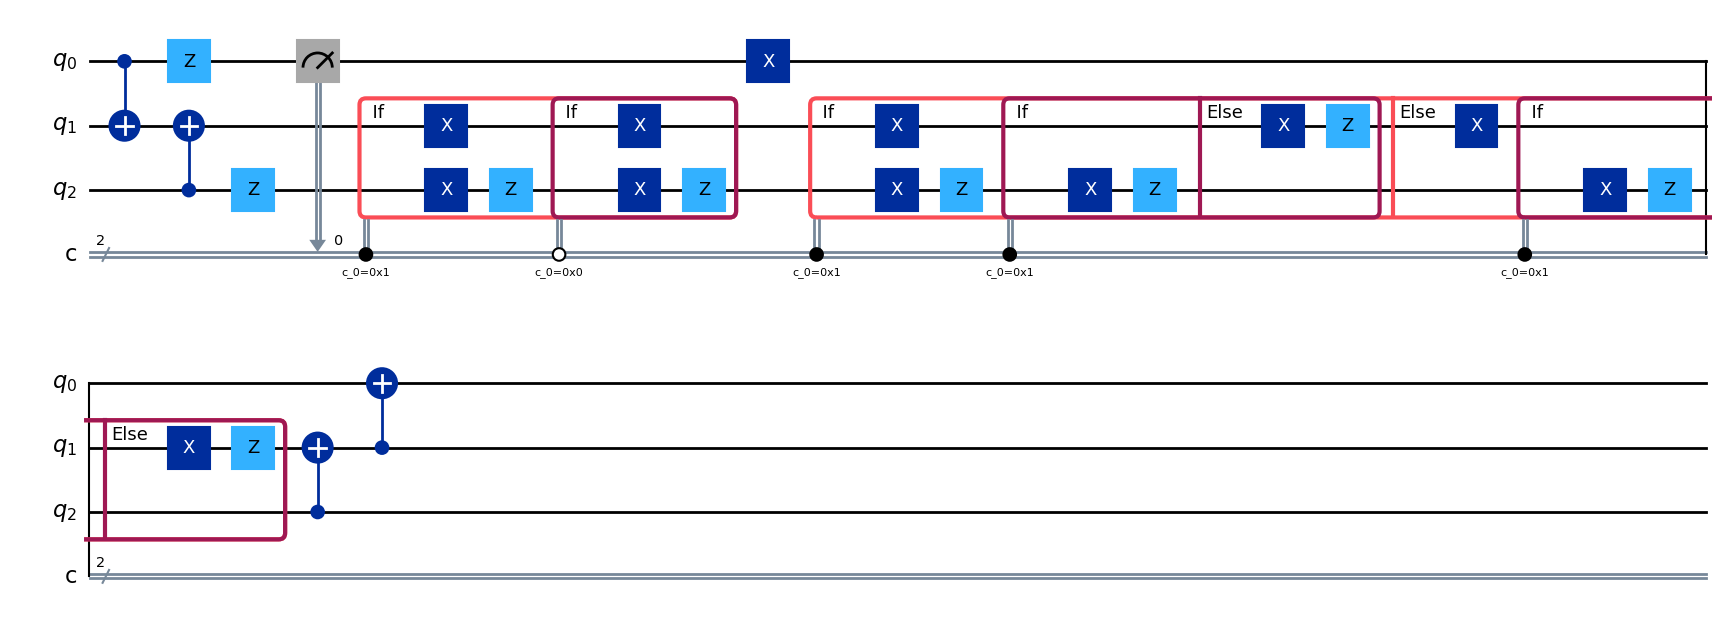

In [3]:
# Create a test circuit
# Note: uncomment the measure instructions to see the difference: optimizations will be disabled

main_circuit = QuantumCircuit(3, 2)

main_circuit.cx(0, 1)
main_circuit.cx(2, 1)
main_circuit.z([0, 2])

# Measure qubit-0
main_circuit.measure(0, 0)

# Add the if-else instruction based on condition on classical bit
with main_circuit.if_test((0, 1)):
    # main_circuit.measure(0, 0)
    main_circuit.x(2)
    main_circuit.x(1)
    main_circuit.z(2)
    with main_circuit.if_test((0, 0)):
        main_circuit.x(2)
        main_circuit.x(1)
        main_circuit.z(2)
with main_circuit.if_test((0, 1)) as else1:
    # main_circuit.measure(1, 0)
    main_circuit.x(2)
    main_circuit.x(1)
    main_circuit.z(2)
    with main_circuit.if_test((0, 1)) as else2:
        main_circuit.x(2)
        main_circuit.z(2)
    with else2:
        main_circuit.x(1)
        main_circuit.z(1)
with else1:
    # main_circuit.measure(1, 1)
    main_circuit.x(1)
    with main_circuit.if_test((0, 1)) as else2:
        main_circuit.x(2)
        main_circuit.z(2)
    with else2:
        main_circuit.x(1)
        main_circuit.z(1)

# More gates
main_circuit.x(0)
main_circuit.cx(2, 1)
main_circuit.cx(1, 0)

# Draw the main circuit
main_circuit.draw('mpl')

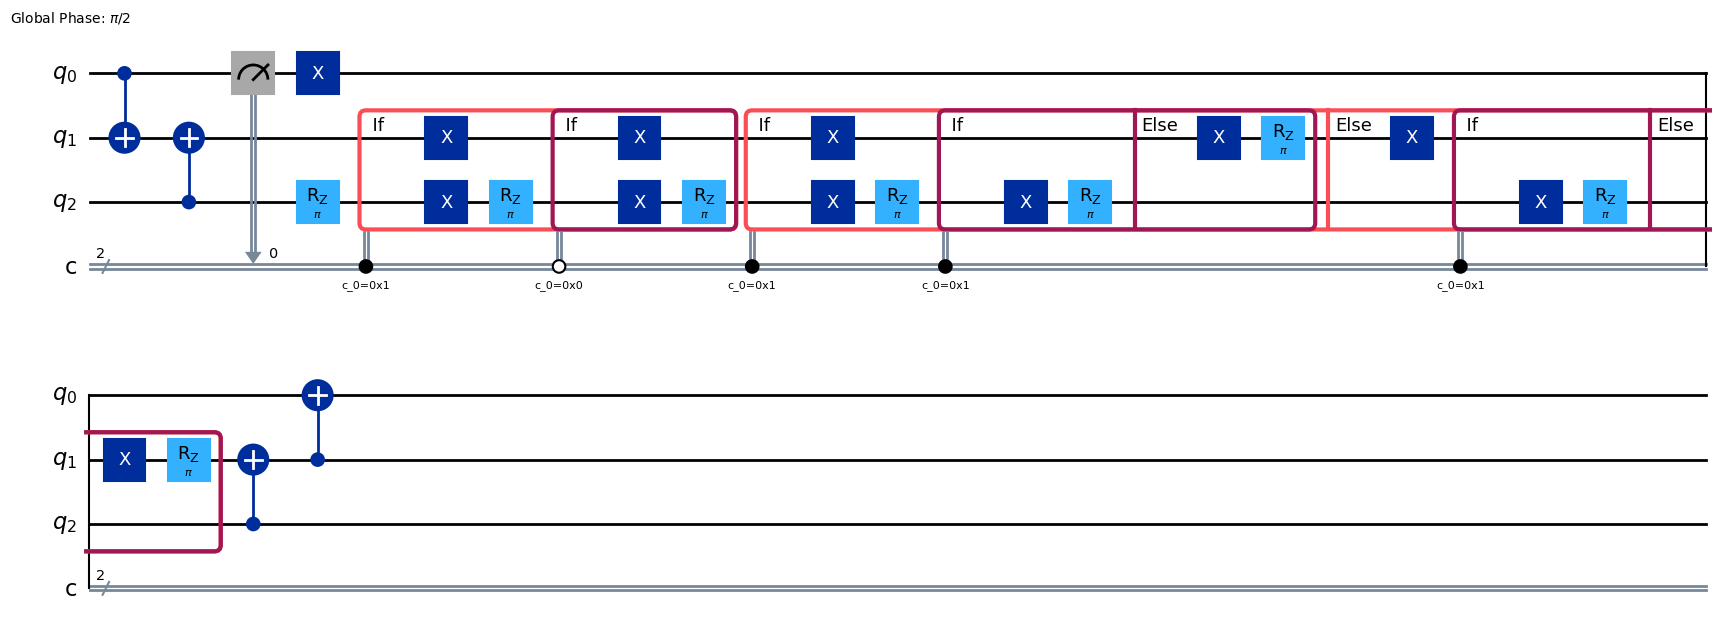

In [4]:
# Run qiskit built-in optimization
basis = ['rz', 'sx', 'x', 'cx']
qc1 = transpile(main_circuit, basis_gates=basis, optimization_level=3)
qc1.draw('mpl')

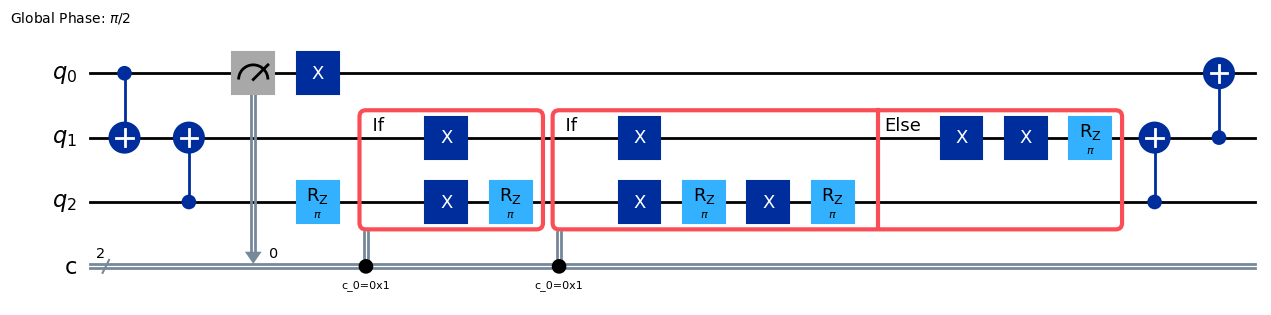

In [5]:
# Run our optimization pass
qc2 = collapse_if_else(qc1)
qc2.draw('mpl')

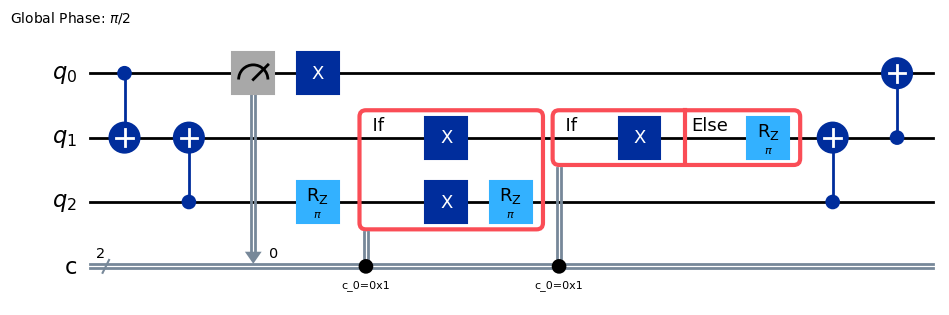

In [6]:
# Rerun qiskit optimizations
# Since our pass removed the if/else barrier, qiskit will be able to optimize the circuit further
new_qc = transpile(qc2, basis_gates=basis, optimization_level=3)
new_qc.draw('mpl')